# Training a model

This notebook takes input TTrees that contain event-level branches and classifies between different groups of events.

## Preparing the dataframe

In [1]:
import os, sys
import numpy as np
import uproot
import pandas as pd

In [2]:
#Global parameters:
indir = '../../input_trees/ForTraining/'
#indir = '../../input_trees_modified/'
chno = 0 #mumu 

In [3]:
#Given a TFile, read its branches into a dataframe.
def read_file_into_df(filepath, truth):

    filename = filepath.split('/')[-1]
    sample = filename.split("_")[1]
    subsample = "_".join(filename.split("_")[2:])
    
    #Exceptions
    if 'QCD' in filename or 'VLL' in filename:
        sample = filename.split("_")[1]+"_"+filename.split("_")[2]
        subsample = filename.split("_")[3].split(".")[0]
        
    if subsample.endswith(".root"): subsample = subsample[:-5]

    tfile = uproot.open(filepath)
    ttree = tfile['myEvents']
    branches = ttree.keys()
    awkarray = ttree.arrays(branches)
    df = pd.DataFrame(awkarray.to_list())
    df['truth'] = truth
    df['sample'] = sample
    df['subsample'] = subsample

    #print(f'dataframe for {sample} {subsample} loaded.')
    return df

def prepare_df(jobname, samples, truth, nmax=None):
    print(f'\nPicking files from {os.path.join(indir, jobname)}')
    dfout = pd.DataFrame()
    for s in samples:
        files = os.listdir(os.path.join(indir, jobname))
        for f in files:
            if s not in f: continue
            filepath = os.path.join(indir, jobname, f)
            df = read_file_into_df(filepath, truth)
            if df.empty:
                print(f"\033[0;31mWarning: Skipping empty file: {f}\033[0m")
                continue
            else:
                #Skim df:
                if nmax is not None and len(df) > nmax:
                    df = df.sample(frac=1).reset_index(drop=True)
                    df = df.head(nmax)
                    
                dfout = pd.concat([dfout, df], ignore_index=True)
                print(f"dataframe for {f} loaded.")

    return dfout

print('Functions loaded.')

Functions loaded.


### Reading the trees into dataframes

In [4]:
%%time

bkgsamples = ['QCD_MuEnriched', 'QCD_EMEnriched']
'''
bkgsamples = ['TTBar_TTToSemiLeptonic', 'TTBar_TTTo2L2Nu',
              'WW_WWTo1L1Nu2Q', 'WW_WWTo2L2Nu', 'WW_WWTo4Q',
              'WZ_WZTo1L1Nu2Q', 'WZ_WZTo2Q2L', 'WZ_WZTo3LNu',
              'ZZ_ZZTo2L2Nu', 'ZZ_ZZTo2Q2L', 'ZZ_ZZTo2Q2Nu', 'ZZ_ZZTo4L'
             ]
'''
#sigsamples = ['VLLD_mu_M100', 'VLLD_mu_M200', 'VLLD_mu_M300', 'VLLD_mu_M400'] #, 'VLLD_mu_M600', 'VLLD_mu_M800']
#sigsamples = ['VLLD_mu_M200', 'VLLD_mu_M300', 'VLLD_mu_M400', 'VLLD_mu_M600', 'VLLD_mu_M800']
#sigsamples = ['VLLD_ele_M200', 'VLLD_ele_M300', 'VLLD_ele_M400', 'VLLD_ele_M600', 'VLLD_ele_M800']
#sigsamples = ['VLLD_mu_M100']
sigsamples = ['VLLD_ele_M100']

bkgdf = prepare_df('tree_forTraining_Sept30_2LSSincl', bkgsamples, 0)
sigdf = prepare_df('tree_forTraining_Sept30_2LSSincl', sigsamples, 1)
#bkgdf = prepare_df('tree_2LSS_baseline_Oct03_evalOct03', bkgsamples, 0, nmax = 3000)
#sigdf = prepare_df('tree_2LSS_baseline_Oct03_evalOct03', sigsamples, 1)

#bkgdf = prepare_df('tree_2LSS_SE2_Oct11', bkgsamples, 0, nmax = 2000)
#sigdf = prepare_df('tree_2LSS_SE2_Oct11', sigsamples, 1)

print('\033[1;32mDone reading samples.\033[0m\n')

modelname = 'qcd-vs-vlld-ele-m100-oct21'
os.makedirs(modelname, exist_ok=True)

print('Ready to proceed.')


Picking files from ../../input_trees/ForTraining/tree_forTraining_Sept30_2LSSincl
dataframe for tree_QCD_MuEnriched_120to170.root loaded.
dataframe for tree_QCD_MuEnriched_170to300.root loaded.
dataframe for tree_QCD_MuEnriched_20to30.root loaded.
dataframe for tree_QCD_MuEnriched_300to470.root loaded.
dataframe for tree_QCD_MuEnriched_30to50.root loaded.
dataframe for tree_QCD_MuEnriched_470to600.root loaded.
dataframe for tree_QCD_MuEnriched_50to80.root loaded.
dataframe for tree_QCD_MuEnriched_600to800.root loaded.
dataframe for tree_QCD_MuEnriched_800to1000.root loaded.
dataframe for tree_QCD_MuEnriched_80to120.root loaded.
dataframe for tree_QCD_EMEnriched_120to170.root loaded.
dataframe for tree_QCD_EMEnriched_170to300.root loaded.
dataframe for tree_QCD_EMEnriched_300toInf.root loaded.
dataframe for tree_QCD_EMEnriched_30to50.root loaded.
dataframe for tree_QCD_EMEnriched_50to80.root loaded.
dataframe for tree_QCD_EMEnriched_80to120.root loaded.

Picking files from ../../input_

In [5]:
nsig_og = sigdf.shape[0]
nbkg_og = bkgdf.shape[0]
print(f'Signal: {nsig_og}')
print(f'Background: {nbkg_og}')

'''
# Maintaining equal proportions of backgrounds:
# Step 1: Get the background sample counts where df['truth'] == 0
bkg_counts = bkgdf['sample'].value_counts()
# Print individual background counts before balancing
print("\nIndividual background counts before balancing:")
for sample, count in bkg_counts.items(): print(f'{sample:<7} : {count}')
    
# Separate small and large background samples
small_samples = bkg_counts[bkg_counts < 100]
large_samples = bkg_counts[bkg_counts >= 100]
# Step 2: Downsample large background samples to the minimum count among them
if large_samples.nunique() != 1:
    min_count = large_samples.min()
    print(f'min = {min_count}')
    # Downsample each large sample to the minimum count
    downsampled_bkg = pd.concat([
        bkgdf[bkgdf['sample'] == sample].sample(n=min_count, random_state=42)
        for sample in large_samples.index
    ])
    small_bkg = bkgdf[bkgdf['sample'].isin(small_samples.index)]
    # Combine the downsampled large background, small background, and signal
    df_balanced = pd.concat([downsampled_bkg, small_bkg])
else:
    df_balanced = bkgdf
    
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_counts = df_balanced['sample'].value_counts()
print("\nIndividual background counts after balancing:")
for sample, count in balanced_counts.items(): print(f'{sample:<7} : {count}')
nbkg = df_balanced.shape[0]
print('-'*15+'\n'+f'{"Total":<7} : {nbkg}')

# Balancing with signal:
bkgdf_reduced = df_balanced.sample(n=6000, random_state=42).reset_index(drop=True)
nbkg = bkgdf.shape[0]
print(f'\nTotal background after dropping random branches: {nbkg}')
'''

#Filtering:
filter = 'lep0_iso < 1.0 and lep1_iso < 1.0'
sigdf = sigdf.query(filter)
bkgdf = bkgdf.query(filter)
bkgdf_reduced = bkgdf.sample(n=8000, random_state=42).reset_index(drop=True)

#Concatenating and filtering:
df = pd.concat([sigdf, bkgdf_reduced])
#df = pd.concat([sigdf, bkgdf])
#df = df.query('lep0_iso < 1.0 and lep1_iso < 1.0')
nsig = df[df['truth'] == 1].shape[0]
nbkg = df[df['truth'] == 0].shape[0]

print(f'Final signal and background: {nsig}, {nbkg}')

Signal: 9183
Background: 333492
Final signal and background: 7804, 8000


### Filtering the dataframe

In [6]:
df

,channel,nlep,njet,nbjet,lep0_pt,lep0_eta,lep0_phi,lep0_iso,lep0_sip3d,lep0_mt,...,dphi_metlep_min,jec,jer,wt_leptonSF,wt_trig,wt_bjet,weight,truth,sample,subsample
0,3,2,2,1,56.226555,2.060547,-0.424744,0.000000,6.660156,142.975601,...,0.569580,1.0,1.014238,0.969027,0.997806,0.856843,0.966901,1,VLLD_ele,M100
1,3,2,0,0,81.486595,-2.013184,2.182129,0.000000,1.063477,215.698502,...,1.786644,1.0,1.000000,1.026827,0.953162,1.000000,0.978732,1,VLLD_ele,M100
2,3,2,2,0,45.210594,-1.842041,-0.870483,0.039930,2.423828,190.584702,...,0.239746,1.0,1.008648,0.957237,0.953162,0.826175,0.912402,1,VLLD_ele,M100
3,0,2,0,0,33.936867,-2.137207,2.710938,0.014142,0.125244,155.470520,...,2.024643,1.0,1.000000,0.973729,0.953162,1.000000,0.928122,1,VLLD_ele,M100
4,0,2,0,0,93.714066,1.062988,-1.969238,0.000000,0.091187,201.558533,...,1.360352,1.0,1.000000,0.976895,0.997546,1.000000,0.974498,1,VLLD_ele,M100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0,2,2,1,131.903366,-0.114395,0.993774,0.945317,14.515625,239.996796,...,0.061035,1.0,0.995791,0.982864,0.997546,0.952491,0.980452,0,QCD_MuEnriched,300to470
7996,1,2,1,0,57.276333,1.925049,2.030273,0.361671,3.455078,3.653674,...,0.023438,1.0,0.999231,1.005591,0.953162,1.000000,0.958491,0,QCD_MuEnriched,170to300
7997,0,2,3,0,84.039841,0.582275,-2.624512,0.516408,0.617188,30.053658,...,0.832502,1.0,0.970077,0.987537,0.950463,1.000000,0.938618,0,QCD_MuEnriched,170to300
7998,2,2,2,1,175.089432,-1.874512,1.492676,0.043741,2.087891,9.927165,...,0.080566,1.0,0.998411,0.989237,0.997680,0.949631,0.986942,0,QCD_MuEnriched,600to800


### Exploring the variables

In [7]:
import matplotlib.pyplot as plt
import math
os.makedirs(f'{modelname}/before_training', exist_ok=True)

def latexname(var, alias): return alias.get(var, var) #Either get the latexname, or return the default name.

def plot_in_group(listvar, figname, suptitle=None, alias=None):
    num_vars = len(listvar)
    ncols = 4
    nrows = math.ceil(num_vars / ncols)
    vertical_size = nrows * 2.5
    
    fig, ax = plt.subplots(nrows, ncols, figsize=(12, vertical_size))
    ax = ax.flatten()
    
    decorate_hist = {
        'bins':'auto',
        'histtype':'step',
        'linewidth':1.5,
        'density':True,
        'log':False
    }
    
    for i, var in enumerate(listvar):        
        sigdata = df[df['truth'] == 1][var]
        bkgdata = df[df['truth'] == 0][var]
        nsig = len(sigdata)
        nbkg = len(bkgdata)
        ax[i].hist(sigdata, label=f'sig [{nsig}]', color='xkcd:green', **decorate_hist)
        ax[i].hist(bkgdata, label=f'bkg [{nbkg}]', color='xkcd:blue',  **decorate_hist)
        if not alias: ax[i].set_title(var, fontsize=10)
        else: ax[i].set_title(latexname(var, alias), fontsize=10)
        ax[i].legend(loc='best', fontsize=8)
        ax[i].tick_params(axis='both', labelsize=6)
    
    for j in range(i+1, len(ax)): fig.delaxes(ax[j])

    if suptitle: fig.suptitle(suptitle, fontsize=12)
    
    
    plt.tight_layout()
    plt.savefig(f'{modelname}/before_training/{figname}.png', dpi=300)
    plt.show()

print('Ready to plot!')

Ready to plot!


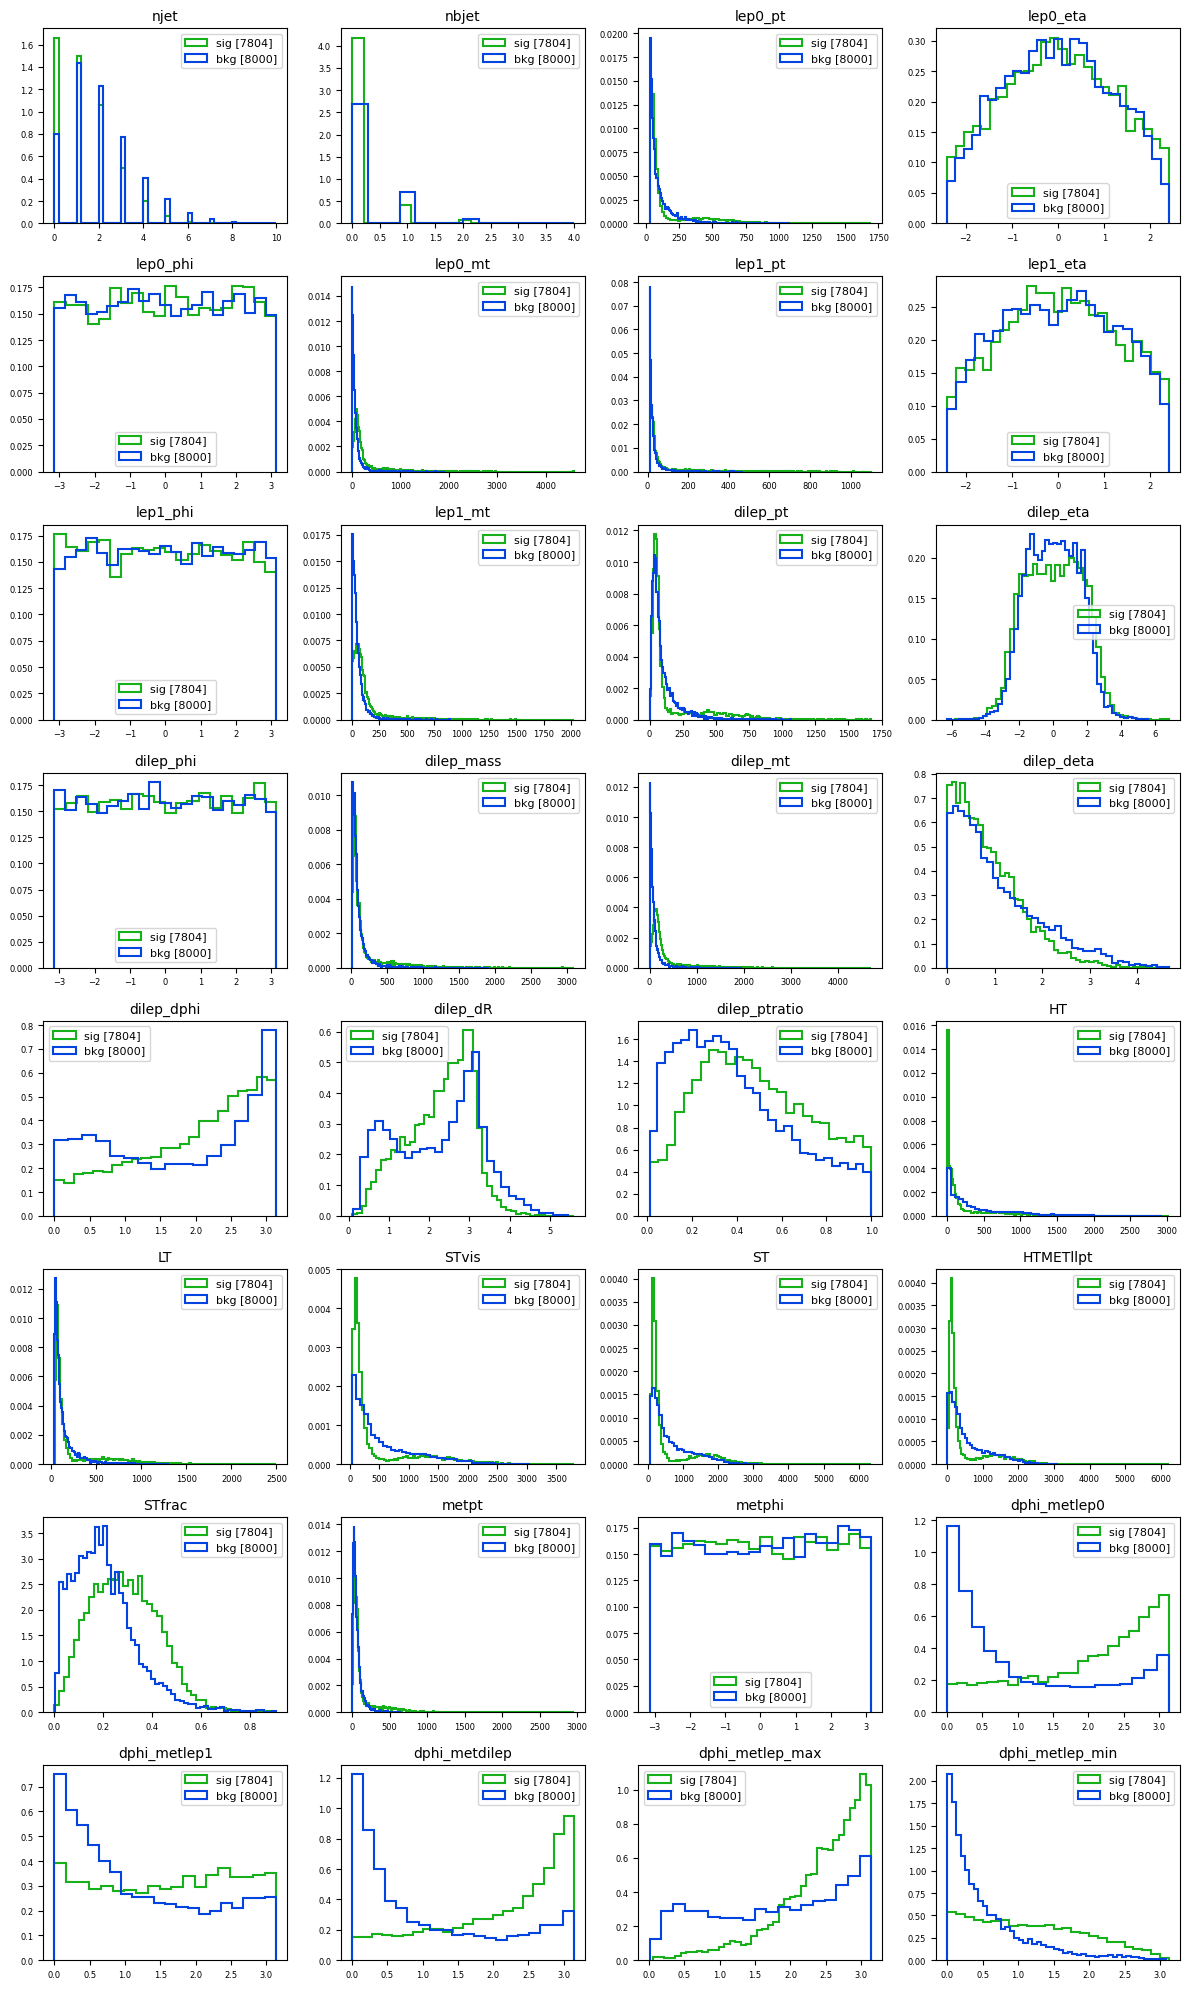

In [8]:
allvar = list(df.keys())

skipvar = ['channel', 'nlep', 'lep0_iso', 'lep0_sip3d', 'lep1_iso', 'lep1_sip3d',
           'jec', 'jer','wt_leptonSF', 'wt_trig', 'wt_bjet', 'weight', 'truth', 'sample', 'subsample',
           #'flag_qcd', 'flag_searchregion', 'trigger'
          ]
plotvar = [var for var in allvar if var not in skipvar]

plot_in_group(plotvar, 'exploring_all_var')

### Deciding which variables to train on

The following input variables are chosen.
njet                $N_{\text{J}}$
dilep_dR            $\Delta R(L_{0}, L_{1})$
dilep_ptratio       $p_{T1}/p_{T0}$
HT                  $H_{T}$
LT                  $L_{T}$
STfrac              $S_{T}^{\text{  frac}}$
metpt               metpt
dphi_metlep0        $\Delta\phi(L_{0}, p_{T}^{\text{  miss}})$
dphi_metdilep       $\Delta\phi(LL, p_{T}^{\text{  miss}})$


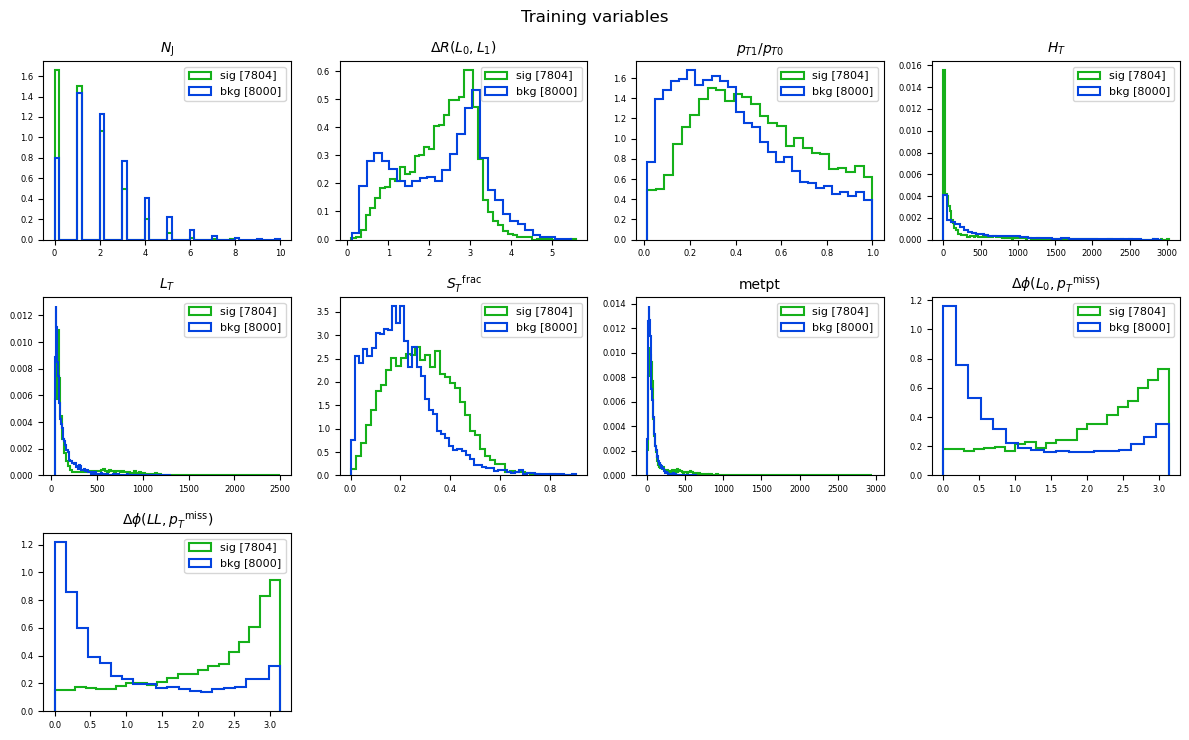

In [9]:
train_var = []

if modelname in ['qcd-vs-vlld-mu-m200-800-oct21', 'qcd-vs-vlld-ele-m200-800-oct21', 'qcd-vs-vlld-mu-m100-oct21', 'qcd-vs-vlld-ele-m100-oct21']:
    train_var = [
        'njet',
        'dilep_dR',
        'dilep_ptratio',
        'HT',
        'LT',
        'STfrac',
        'metpt',
        'dphi_metlep0',
        'dphi_metdilep'
    ]

alias_ = {
    'njet':            r'$N_{\text{J}}$',
    'lep0_eta':        r'$\eta (L_0)$',
    'lep1_eta':        r'$\eta (L_1)$',
    'dilep_mt':        r'$M_{T}^{\text{  LL}}$',
    'dilep_dR':        r'$\Delta R(L_{0}, L_{1})$',
    'dilep_dphi':      r'$\Delta\phi(L_{0}, L_{1})$',
    'dilep_deta':      r'$\Delta\eta(L_{0}, L_{1})$',
    'dilep_ptratio':   r'$p_{T1}/p_{T0}$',
    'HTMETllpt':       r'$H_{T}+p_{T}^{\text{  miss}}+ p_T^{\text{  LL}}$',
    'HT':              r'$H_{T}$',
    'LT':              r'$L_{T}$',
    'STfrac':          r'$S_{T}^{\text{  frac}}$',
    'dphi_metlep0':    r'$\Delta\phi(L_{0}, p_{T}^{\text{  miss}})$',
    'dphi_metdilep':   r'$\Delta\phi(LL, p_{T}^{\text{  miss}})$',
    'dphi_metlep_max': r'$max\{\Delta\phi(L, p_{T}^{\text{  miss}})\}$',
    'dphi_metlep_min': r'$min\{\Delta\phi(L, p_{T}^{\text{  miss}})\}$'
} #Uses these names in plot. If not mentioned here, uses the dafault name.

print('The following input variables are chosen.')
for var in train_var: print(f"{var:<20}{latexname(var, alias_)}")

plot_in_group(train_var, 'training_varriables', suptitle='Training variables', alias=alias_)

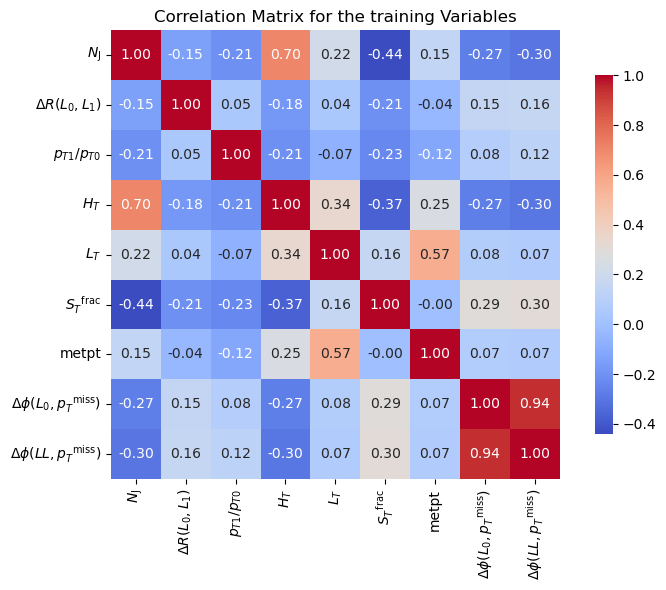

In [10]:
import seaborn as sns

correlation_data = df[train_var]
correlation_matrix = correlation_data.corr()

fig, ax = plt.subplots(figsize=(8, 6))

#sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, 
#            cbar_kws={"shrink": .8}, ax=ax, xticklabels=train_var, yticklabels=train_var)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, 
            cbar_kws={"shrink": .8}, ax=ax, 
            xticklabels=[latexname(var, alias_) for var in train_var],  # Use LaTeX aliases for x-axis labels
            yticklabels=[latexname(var, alias_) for var in train_var])  # Use LaTeX aliases for y-axis labels

ax.set_title('Correlation Matrix for the training Variables', fontsize=12)

plt.tight_layout()
plt.savefig(f'{modelname}/before_training/correlation_trainvar.png', dpi=300, bbox_inches='tight')
plt.show()

## Preparing the Neural Network

In [11]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from tensorflow import keras
from keras import layers

2024-10-21 11:28:43.298271: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Training and testing dataset

In [12]:
df = df.sample(frac=1).reset_index(drop=True)
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df['truth'])

#Randomizing again:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test  = df_test.sample(frac=1).reset_index(drop=True)

nsig_train = len(df_train.query('truth == 1'))
nsig_test  = len(df_test.query('truth == 1'))
nbkg_train = len(df_train.query('truth == 0'))
nbkg_test  = len(df_test.query('truth == 0'))

print(f'Statistics:')
print(f'nSig split into train and test: {nsig_train}, {nsig_test}')
print(f'nBkg split into train and test: {nbkg_train}, {nbkg_test}')

Statistics:
nSig split into train and test: 5462, 2342
nBkg split into train and test: 5600, 2400


### Min-max scaling

In [13]:
def FindMinMax(X, modelname):
    # Calculate min and max values
    maxval = X.max(axis=0)
    minval = X.min(axis=0)
    print('\n' + '-' * 25)
    print("Min Values found: ", minval)
    print("Max Values found: ", maxval)
    
    # Save min and max values to separate text files without headers
    np.savetxt(f'{modelname}/scaling_parameters_min.txt', minval, fmt='%.6f')
    np.savetxt(f'{modelname}/scaling_parameters_max.txt', maxval, fmt='%.6f')

def ApplyMinMax(X, min_filename, max_filename):
    # Load min values from the file
    minval = np.loadtxt(min_filename)
    
    # Load max values from the file
    maxval = np.loadtxt(max_filename)
    
    #print('Min from txt: ', minval)
    #print('Max from txt: ', maxval)
    
    # Calculate the difference
    diff = maxval - minval
    normed_X = X.copy()    
    # Scale the data only for non-constant columns
    nonconst = np.where(diff != 0)[0]
    normed_X[:, nonconst] = 2 * ((X[:, nonconst] - minval[nonconst]) / diff[nonconst]) - 1.0
    
    return normed_X

print('Functions for min-max scaling ready.')

Functions for min-max scaling ready.


In [14]:
#Numpy arrays that go into the training and testing:
X_train= df_train[train_var].values
y_train= df_train['truth'].values
X_test = df_test[train_var].values
y_test = df_test['truth'].values

FindMinMax(X_train, modelname)

X_train = ApplyMinMax(X_train, f'{modelname}/scaling_parameters_min.txt', f'{modelname}/scaling_parameters_max.txt')
X_test  = ApplyMinMax(X_test,  f'{modelname}/scaling_parameters_min.txt', f'{modelname}/scaling_parameters_max.txt')


-------------------------
Min Values found:  [0.00000000e+00 1.02257624e-01 1.17495796e-02 0.00000000e+00
 3.62055779e+01 1.42200175e-03 6.76352322e-01 0.00000000e+00
 9.39369202e-05]
Max Values found:  [1.00000000e+01 5.59767199e+00 9.99942124e-01 3.02575928e+03
 2.49762109e+03 9.04892743e-01 1.82661609e+03 3.14147925e+00
 3.14152288e+00]


In [15]:
column_index = 1  # Replace 'i' with the column index you're interested in
print(np.min(X_train[:, column_index]), np.max(X_train[:, column_index]))

-1.0000001367436442 0.9999999947688092


### Defining the model parameters

In [16]:
n_features = X_train.shape[1]
epochs_ = 30
batch_ = 100

model = keras.Sequential([
    layers.Input(shape=(n_features,)),  # Input layer
    layers.Dense(64, activation='relu'),  # Hidden layer
    layers.Dense(32, activation='relu'),  # Hidden layer
    layers.Dense(16, activation='relu'),  # Hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#opt = tf.keras.optimizers.Adam(learning_rate=0.001)

### Training

In [17]:
%%time

history = model.fit(X_train,y_train,epochs=epochs_,batch_size=batch_,validation_data=(X_test,y_test),verbose=1)
model.save(f'{modelname}/model_{modelname}.keras')
print('Training complete!\n')


Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6676 - loss: 0.6079 - val_accuracy: 0.7564 - val_loss: 0.5060
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7506 - loss: 0.4981 - val_accuracy: 0.7801 - val_loss: 0.4459
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7899 - loss: 0.4413 - val_accuracy: 0.7997 - val_loss: 0.4161
Epoch 4/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8039 - loss: 0.4164 - val_accuracy: 0.8165 - val_loss: 0.3818
Epoch 5/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8182 - loss: 0.3917 - val_accuracy: 0.8224 - val_loss: 0.3680
Epoch 6/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8258 - loss: 0.3718 - val_accuracy: 0.8298 - val_loss: 0.3575
Epoch 7/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8187 - loss: 0.3758 - val_accuracy: 0.8313 - val_loss: 0.3513
Epoch 8/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8265 - loss: 0.3673 - val_accuracy: 0.

In [18]:
from io import StringIO

info_filename = f'{modelname}/info_{modelname}.txt'

info = []
info.append(f'Model Name: {modelname}')
info.append(f'Signal and Background before filtering: {nsig}, {nbkg}')
info.append(f'Signal in training: {nsig_train}')
info.append(f'Signal in testing: {nsig_test}')
info.append(f'Background in training: {nbkg_train}')
info.append(f'Background in testing: {nbkg_test}')
info.append(f'Training Variables: {train_var}')
info.append(f'Number of Epochs: {epochs_}')
info.append(f'Batch Size: {batch_}')
info.append('\nModel Summary:\n')

model.summary()
buffer = StringIO()
model.summary(print_fn=lambda x: buffer.write(x + '\n'))
model_summary = buffer.getvalue()
info.append(model_summary)

# Write information to file
with open(info_filename, 'w') as f:
    for line in info:
        f.write(line + '\n')

print(f'Information saved to {info_filename}')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,797 (38.27 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,532 (25.52 KB)

Information saved to qcd-vs-vlld-ele-m100-oct21/info_qcd-vs-vlld-ele-m100-oct21.txt


### Loss and accuracy

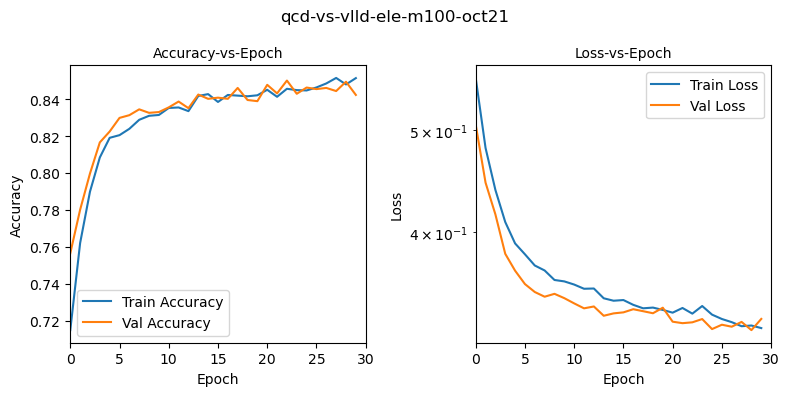

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Subplot 1: accuracy vs epoch
ax[0].plot(history.history['accuracy'],     label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Val Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_xlim(0, epochs_)
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy-vs-Epoch', fontsize=10)
ax[0].legend(loc='best')

# Subplot 2: loss vs epoch
ax[1].plot(history.history['loss'],     label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_xlim(0, epochs_)
ax[1].set_ylabel('Loss')
ax[1].set_yscale('log')
ax[1].legend(loc='best')
ax[1].set_title('Loss-vs-Epoch', fontsize=10)

fig.suptitle(modelname, fontsize=12)

plt.tight_layout()
plt.savefig(f'{modelname}/loss-and-accuracy.png')
plt.show()

### Using the trained model to predict

In [20]:
%%time

y_predicted_train = model.predict(X_train)
y_predicted_test  = model.predict(X_test)

df_train['score'] = y_predicted_train
df_test['score']  = y_predicted_test

# ROC information for the test dataset
fpr, tpr, _ = roc_curve(y_test, y_predicted_test)
auc_score = auc(tpr,1-fpr)
tpr=tpr*100
fnr=(1-fpr)*100

# ROC information for training data
fpr1, tpr1, _ = roc_curve(y_train, y_predicted_train)
auc_score1 = auc(tpr1,1-fpr1)
tpr1=tpr1*100
fnr1=(1-fpr1)*100

print('Done!\n')

346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
Done!

CPU times: user 727 ms, sys: 128 ms, total: 854 ms
Wall time: 709 ms


### Performance check

In [21]:
display(df_test)

,channel,nlep,njet,nbjet,lep0_pt,lep0_eta,lep0_phi,lep0_iso,lep0_sip3d,lep0_mt,...,jec,jer,wt_leptonSF,wt_trig,wt_bjet,weight,truth,sample,subsample,score
0,0,2,1,0,44.806732,0.637451,-3.046875,0.266121,2.884766,6.523612,...,1.0,1.014482,0.992279,0.950463,1.000000,0.943124,0,QCD_MuEnriched,120to170,0.011132
1,0,2,0,0,27.172567,0.933716,-2.644531,0.327003,8.921875,21.328621,...,1.0,1.000000,0.958504,0.997545,1.000000,0.956150,0,QCD_MuEnriched,50to80,0.127198
2,0,2,3,0,328.690521,-0.682861,0.765259,0.058163,3.082031,12.761579,...,1.0,1.048504,0.991395,0.950463,1.000000,0.942284,0,QCD_MuEnriched,800to1000,0.007950
3,0,2,1,0,90.314346,-0.500732,-1.509033,0.043783,0.190674,57.226139,...,1.0,0.995065,0.987537,0.950463,1.000000,0.938618,0,QCD_MuEnriched,170to300,0.661541
4,1,2,1,0,100.402054,-0.017834,1.911621,0.033459,1.208008,151.401871,...,1.0,1.139042,0.978043,0.997680,0.922122,0.975774,1,VLLD_ele,M100,0.324733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4737,0,2,5,0,270.522369,0.180756,-2.685059,0.367094,10.398438,97.106659,...,1.0,1.016133,0.974890,0.997546,1.000000,0.972497,0,QCD_MuEnriched,470to600,0.081880
4738,1,2,1,0,495.169067,0.181732,1.750244,0.149834,6.992188,38.765015,...,1.0,1.013004,1.026736,0.950463,0.940157,0.975874,0,QCD_MuEnriched,800to1000,0.007368
4739,1,2,0,0,41.700451,-1.562256,-1.072266,0.000000,0.011406,140.919601,...,1.0,1.000000,0.979020,0.997806,1.000000,0.976872,1,VLLD_ele,M100,0.991723
4740,0,2,3,0,57.637913,0.485840,1.605957,0.480708,4.535156,34.807835,...,1.0,1.031835,1.002188,0.950463,1.000000,0.952542,0,QCD_MuEnriched,120to170,0.254354


In [22]:
%%capture

mybins = np.arange(0, 1.02, 0.02)
density_ = False

def extract_plot(df_, truth_, mybins, density_):
    scores_ = df_[df_['truth'] == truth_]['score']
    hist_ = plt.hist(scores_, bins=mybins, density=density_)
    counts_, bins_, _ = hist_
    errors_ = np.sqrt(counts_)
    integral_ = np.sum(counts_)
    scale_ = integral_ / len(scores_) if len(scores_) > 0 else 1
    weights_ = np.ones_like(scores_)
    if density_ == True: weights_ = np.ones_like(scores_) * (scale_ / len(scores_)) #Normalise integral to 1    
    return scores_, bins_, weights_, counts_, errors_

train_scores_sig, bins_sig_train, weights_sig_train, counts_sig_train, errors_sig_train = extract_plot(df_train, 1, mybins, density_)
train_scores_bkg, bins_bkg_train, weights_bkg_train, counts_bkg_train, errors_bkg_train = extract_plot(df_train, 0, mybins, density_)
test_scores_sig, bins_sig_test, weights_sig_test, counts_sig_test, errors_sig_test =      extract_plot(df_test,  1, mybins, density_)
test_scores_bkg, bins_bkg_test, weights_bkg_test, counts_bkg_test, errors_bkg_test =      extract_plot(df_test,  0, mybins, density_)

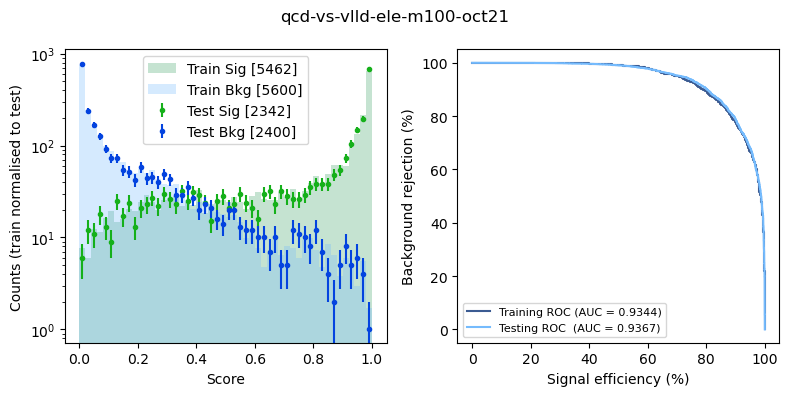

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

decorate_hist = {
    'bins':mybins,
    'histtype':'step',
    'linewidth':1.5,
    'density': density_,
    'log': False,
    'alpha':1.0
}

decorate_point ={
    'marker':'o',
    'markersize':3,
    'linestyle':''
}

if density_:
    ax[0].hist(train_scores_sig, color='xkcd:greenish', label=f'Train Sig [{len(train_scores_sig)}]', alpha=0.3, bins=mybins, density=density_)
    ax[0].hist(train_scores_bkg, color='xkcd:sky blue', label=f'Train Bkg [{len(train_scores_bkg)}]', alpha=0.3, bins=mybins, density=density_)
    ax[0].hist(test_scores_sig,  color='xkcd:green', label=f'Test Sig [{len(test_scores_sig)}]', **decorate_hist)
    ax[0].hist(test_scores_bkg,  color='xkcd:blue',  label=f'Test Bkg [{len(test_scores_bkg)}]',**decorate_hist)

else:
    # Calculate the scaling factors to normalize train histograms to match test integrals
    scale_factor_sig = np.sum(counts_sig_test) / np.sum(counts_sig_train) if np.sum(counts_sig_train) > 0 else 1
    scale_factor_bkg = np.sum(counts_bkg_test) / np.sum(counts_bkg_train) if np.sum(counts_bkg_train) > 0 else 1

    # Make train plots, normalized to match test histogram integrals
    ax[0].hist(train_scores_sig, color='xkcd:greenish', label=f'Train Sig [{len(train_scores_sig)}]', 
               alpha=0.3, bins=mybins, density=False, weights=np.ones_like(train_scores_sig) * scale_factor_sig)
    ax[0].hist(train_scores_bkg, color='xkcd:sky blue', label=f'Train Bkg [{len(train_scores_bkg)}]', 
               alpha=0.3, bins=mybins, density=False, weights=np.ones_like(train_scores_bkg) * scale_factor_bkg)
    
    # Make test plots with error bars
    ax[0].errorbar(bins_sig_test[:-1] + np.diff(bins_sig_test) / 2, 
                   counts_sig_test, 
                   yerr=errors_sig_test, 
                   color='xkcd:green', label=f'Test Sig [{len(test_scores_sig)}]', 
                   fmt='o', markersize=3)
    
    ax[0].errorbar(bins_bkg_test[:-1] + np.diff(bins_bkg_test) / 2, 
                   counts_bkg_test, 
                   yerr=errors_bkg_test, 
                   color='xkcd:blue', label=f'Test Bkg [{len(test_scores_bkg)}]', 
                   fmt='o', markersize=3)

ax[0].set_xlabel('Score')
if density_:     ax[0].set_ylabel('Counts (normalized)')
if not density_: ax[0].set_ylabel('Counts (train normalised to test)')
ax[0].set_yscale('log')
ax[0].legend(loc='best')

ax[1].plot(tpr, fnr, color='xkcd:denim blue', label='Training ROC (AUC = %0.4f)' % auc_score)
ax[1].plot(tpr1,fnr1,color='xkcd:sky blue',   label='Testing ROC  (AUC = %0.4f)'  % auc_score1)
ax[1].set_xlabel('Signal efficiency (%)')
ax[1].set_ylabel('Background rejection (%)')
ax[1].legend(loc='best', fontsize=8)

fig.suptitle(modelname, fontsize=12)

plt.tight_layout()
plt.savefig(f'{modelname}/performance.png')
plt.show()

### Permutation importance of the training variables

In [24]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
import warnings
import io
from contextlib import redirect_stdout, redirect_stderr

# Suppress warnings
warnings.filterwarnings("ignore")

# Define a scoring function compatible with permutation_importance
def keras_accuracy(model, X, y):
    # Get predictions
    y_pred = model.predict(X)
    # For binary classification, threshold predictions at 0.5
    y_pred_classes = (y_pred > 0.5).astype(int).flatten()
    return accuracy_score(y, y_pred_classes)

# Capture stdout and stderr to suppress output
f = io.StringIO()
with redirect_stdout(f), redirect_stderr(f): 
    # Calculate permutation importance
    result = permutation_importance(
        model,
        X_test,
        y_test,
        n_repeats=30,
        random_state=42,
        n_jobs=-1,
        scoring=keras_accuracy
    )

# Optional: Print or return the result if needed
# print(result)

2024-10-21 11:28:57.249800: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-21 11:28:57.253806: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-21 11:28:57.321186: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-21

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━

Sorted Features and Importance Scores:
dphi_metdilep        0.188
HT                   0.168
metpt                0.084
LT                   0.063
dphi_metlep0         0.038
dilep_dR             0.032
njet                 0.030
STfrac               0.013
dilep_ptratio        0.012


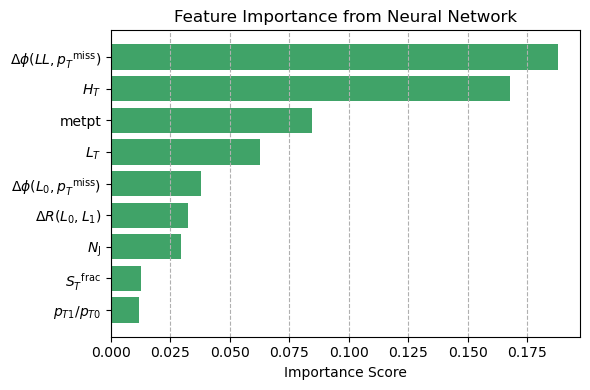

In [25]:
# Get feature importance scores and corresponding variable names
importance_scores = result.importances_mean
feature_names = train_var

# Sort importance scores and corresponding feature names
sorted_indices = np.argsort(importance_scores)[::-1]  # Indices for sorting from most to least
sorted_importance_scores = importance_scores[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]
# Apply LaTeX aliases to the sorted feature names
sorted_feature_names_latex = [latexname(name, alias_) for name in sorted_feature_names]

# Print the sorted features and importance scores
print("Sorted Features and Importance Scores:")
for name, score in zip(sorted_feature_names, sorted_importance_scores):
    print(f"{name:<20} {score:.3f}")

# Prepare the plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(sorted_feature_names_latex, sorted_importance_scores, color='xkcd:greenish')  # Use LaTeX aliases
ax.invert_yaxis()
ax.set_xlabel('Importance Score')
#ax.set_ylabel('Features')
ax.set_title('Feature Importance from Neural Network')
ax.grid(axis='x', linestyle='--')

# Save and show the plot
plt.tight_layout()
plt.savefig(f'{modelname}/feature_importance.png', bbox_inches='tight')  # Save with tight bounding box
plt.show()
